In [2]:
import numpy as np, seaborn as sns, matplotlib.pyplot as plt, pandas as pd

import sys
sys.path.append('/ahg/regevdata/projects/CRISPR-libraries/prj2/evolution/abe8e/src/')
import e_all_fullgts_stats as parent_script
import _config

design_df = pd.read_csv(_config.DATA_DIR + 'exp_design.csv')

Using data folder:
 /ahg/regevdata/projects/CRISPR-libraries/prj2/evolution/abe8e/data/


In [5]:
ddf = dict()
mdf = pd.DataFrame()
for nm in design_df['Short name']:
    
    import pickle
    with open(parent_script.out_dir + f'{nm}.pkl', 'rb') as f:
        d = pickle.load(f)
        
    ddf[nm] = d

## stats

In [31]:
def calc_normalized_entropy(d):
    '''
        Ranges from 0 (not diverse) to 1 (most diverse)
    '''
    counts = np.array(list(d.keys()))
    num_gts = np.array(list(d.values()))
    tot = np.dot(counts, num_gts)

    ans = 0
    for count in d.keys():
        num_gt = d[count]
        p = count / tot
        
        ans -= num_gt * p * np.log(p)
    
    total_num_gts = sum(num_gts)
    return ans / np.log(total_num_gts)


print(calc_normalized_entropy(ddf[1]))
print(calc_normalized_entropy({0.25: 4}))
print(calc_normalized_entropy({.99: 1, 0.01: 1}))

from scipy.stats import entropy
print(entropy([0.25] * 4) / np.log(4))
print(entropy([0.99, 0.01]) / np.log(2))

0.75114365177421
1.0
0.08079313589591118
1.0
0.08079313589591118


In [38]:
def calc_isi(d):
    '''
        Highest unnormalized ISI = num.
        Normalized; ranges from ~0 (not diverse) to 1 (most diverse).
    '''
    counts = np.array(list(d.keys()))
    num_gts = np.array(list(d.values()))
    tot = np.dot(counts, num_gts)

    ans = 0
    for count in d.keys():
        num_gt = d[count]
        p = count / tot
        
        ans += num_gt * p**2 

    isi = 1 / ans
    return isi / sum(num_gts)

print(calc_isi(ddf[1]))
print(calc_isi({0.25: 4}))
print(calc_isi({0.99: 1, 0.01: 1}))


0.0011470283362522674
1.0
0.5100999795960008


In [126]:
def calc_L(d, frac = 0.5):
    '''
        Normalized; fraction of total gts observed that 
    '''
    counts = np.array(list(d.keys()))
    num_gts = np.array(list(d.values()))
    tot = np.dot(counts, num_gts)

    threshold = tot * frac
    
    rsum = 0
    n = 0
    keys = sorted(list(d.keys()), reverse = True)
    for count in keys:
        num_gt = d[count]
        for jdx in range(num_gt):
            rsum += count
            n += 1
            if rsum >= threshold:
                return n
    return None
    
calc_L(ddf[1], frac = 0.5)

364

In [127]:
def calc_L_normalized(d, frac = 0.5):
    '''
        Normalized; fraction of total gts observed that 
    '''
    counts = np.array(list(d.keys()))
    num_gts = np.array(list(d.values()))
    tot = np.dot(counts, num_gts)

    threshold = tot * frac
    
    rsum = 0
    n = 0
    keys = sorted(list(d.keys()), reverse = True)
    for count in keys:
        num_gt = d[count]
        for jdx in range(num_gt):
            rsum += count
            n += 1
            if rsum >= threshold:
                return n / sum(num_gts)
    return None
    
calc_L_normalized(ddf[1], frac = 0.5)

0.0072042116929897475

In [104]:
def calc_max_frequency(d):
    counts = np.array(list(d.keys()))
    num_gts = np.array(list(d.values()))
    tot = np.dot(counts, num_gts)
    
    keys = sorted(list(d.keys()), reverse = True)
    highest_count = keys[0]
    return highest_count / tot

calc_max_frequency(ddf[1])

0.1219845387281959

In [64]:
def threshold(d, low = 10):
    return {ct: d[ct] for ct in d.keys() if ct >= low}

stat_funcs = [
    calc_L
]

master_d = ddf[1]
for low in [0, 5, 10]:
    d = threshold(master_d, low = low)
    
    print(low)
    print('Entropy:', calc_normalized_entropy(d))
    print('ISI:', calc_isi(d))
    print('L50:', calc_L(d))
    print()

0
Entropy: 0.75114365177421
ISI: 0.0011470283362522674
L50: 382

5
Entropy: 0.6848368483228029
ISI: 0.013253045109760286
L50: 167

10
Entropy: 0.7047487075578716
ISI: 0.0241951357065441
L50: 162



## color

In [67]:
palette = {
    'Low Stringency PANCE 1': '#f59890',
    'Low Stringency PANCE 2': '#68c7ec',
    'High Stringency PANCE 1': '#ec4339',
    'High Stringency PANCE 2': '#00a0dc',
    'High Stringency PANCE 3': '#f47b16',
    'High Stringency PANCE 4': '#00aeb3',
    'PACE 1': '#b6b9bc',
    'PACE 2': '#86898c',
    'PACE 3': '#595c5f',
}

colors = [palette[regime] for regime in design_df['Regime']]
labels = list(design_df['Regime'])

design_df['Color'] = colors

## calc

In [132]:
from collections import defaultdict
stats_dd = defaultdict(list)

for nm in ddf:
    master_d = ddf[nm]

    for low in [0, 5, 10]:
        d = threshold(master_d, low = low)

        stats_dd['Name'].append(nm)
        stats_dd['Threshold'].append(low)
        stats_dd['Entropy'].append(calc_normalized_entropy(d))
        stats_dd['ISI'].append(calc_isi(d))
        stats_dd['L50'].append(calc_L(d))
        stats_dd['Normalized L50'].append(calc_L_normalized(d))
        stats_dd['Max frequency'].append(calc_max_frequency(d))
        
stats_df = pd.DataFrame(stats_dd)

design_df['Name'] = design_df['Short name']
stats_df = stats_df.merge(design_df, how = 'outer', on = 'Name')

In [106]:
stats_df.head()

,Name,Threshold,Entropy,ISI,L50,Normalized L50,Max frequency,Regime,Short name,Color
0,1,0,0.751144,0.001147,382,0.007560,0.121985,Low Stringency PANCE 1,1,#f59890
1,1,5,0.684837,0.013253,167,0.117111,0.213642,Low Stringency PANCE 1,1,#f59890
2,1,10,0.704749,0.024195,162,0.237885,0.228819,Low Stringency PANCE 1,1,#f59890
3,2,0,0.766813,0.001541,479,0.011119,0.112946,Low Stringency PANCE 1,2,#f59890
4,2,5,0.699149,0.016870,151,0.127211,0.205658,Low Stringency PANCE 1,2,#f59890


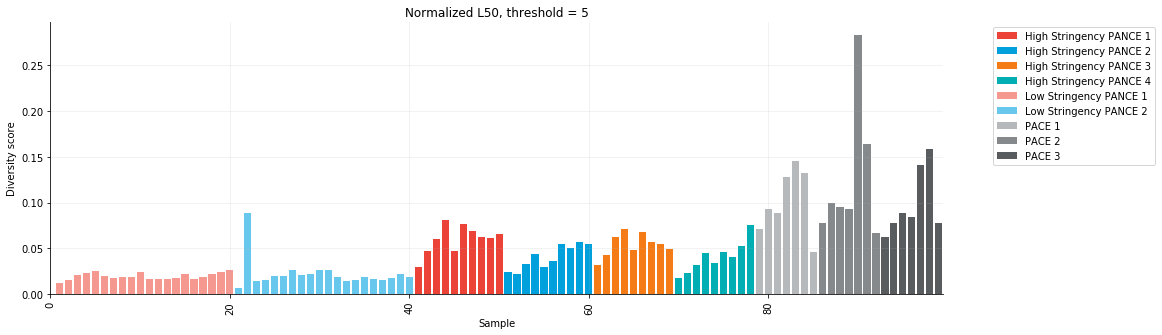

In [133]:
stat_nm = 'Normalized L50'
low = 5

dfs = stats_df[stats_df['Threshold'] == low]

fig, ax = plt.subplots(figsize = (16, 5))
for regime in sorted(list(set(dfs['Regime']))):
    dfsr = dfs[dfs['Regime'] == regime]
    plt.bar(
        dfsr['Name'],
        dfsr[stat_nm],
        color = dfsr['Color'].iloc[0],
        label = regime,
    )

sns.despine()
plt.grid(alpha = 0.2)
plt.xlim(left = 0, right = 99.5)
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')

plt.title(f'{stat_nm}, threshold = {low}')
plt.xticks(rotation = 90);

plt.ylabel('Diversity score')
plt.xlabel('Sample')

plt.show()
plt.close()

## plot all

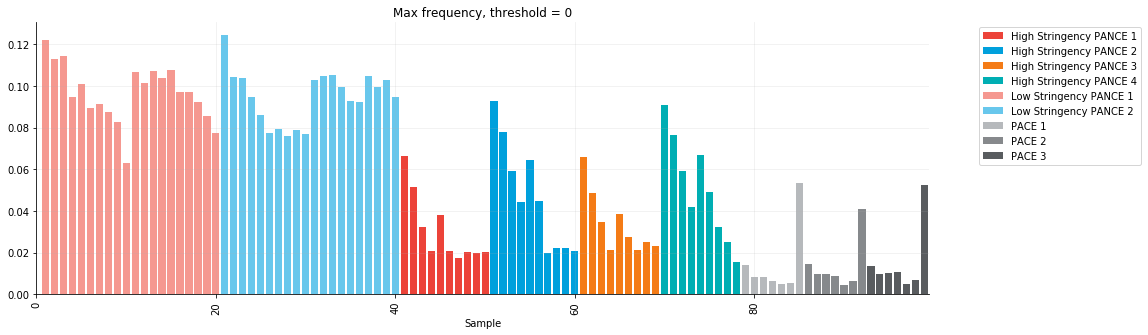

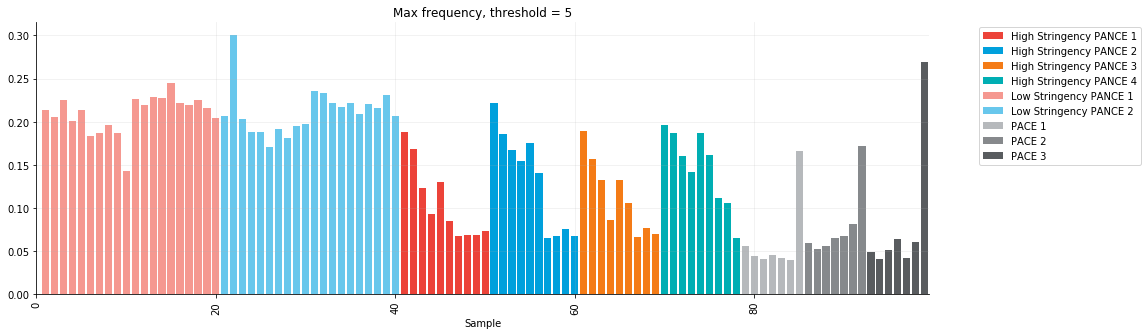

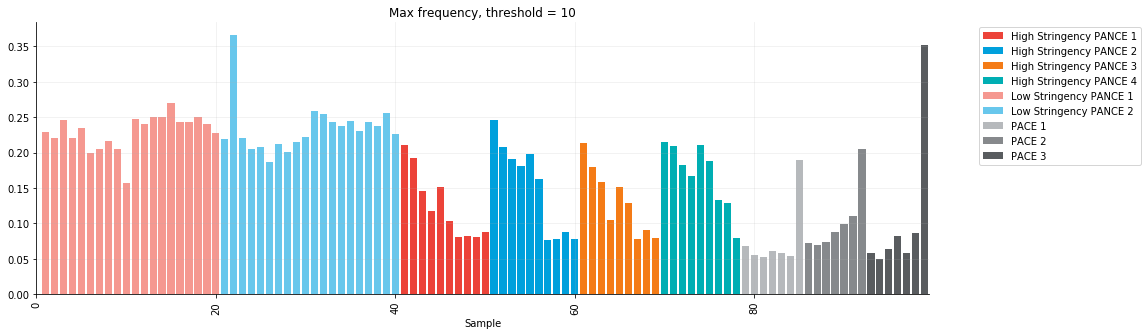

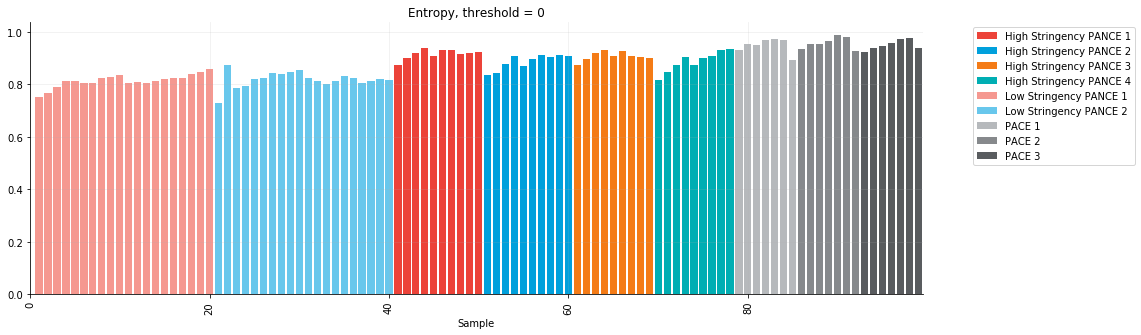

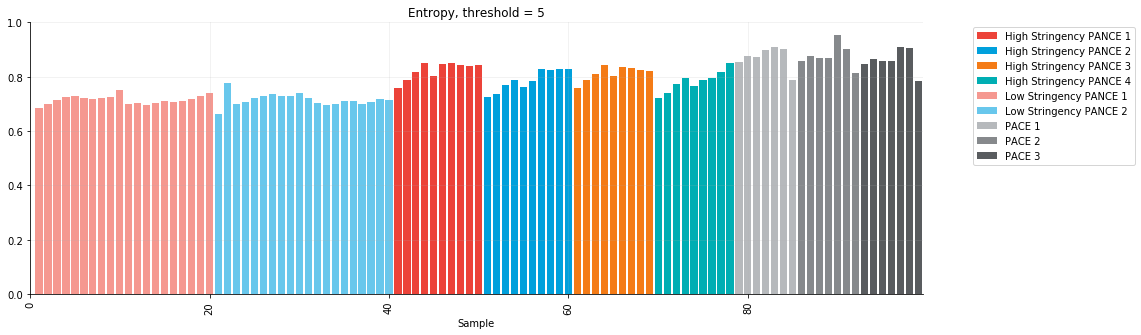

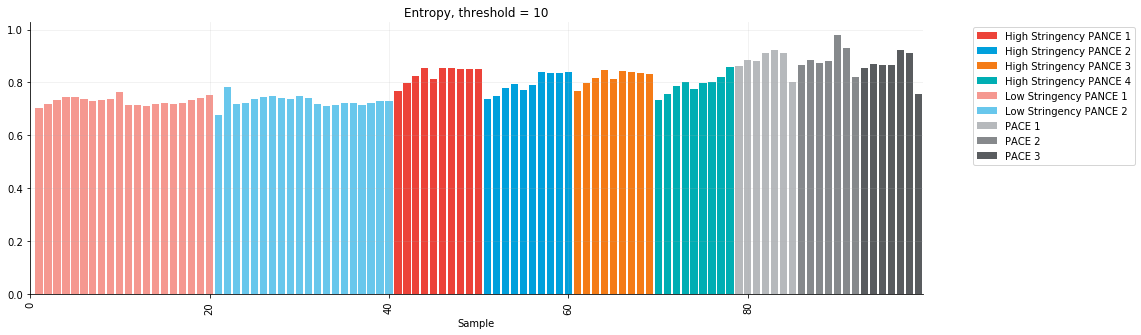

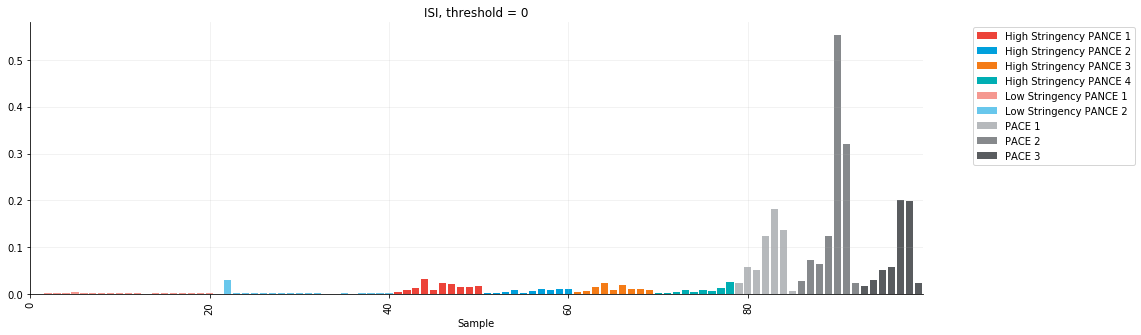

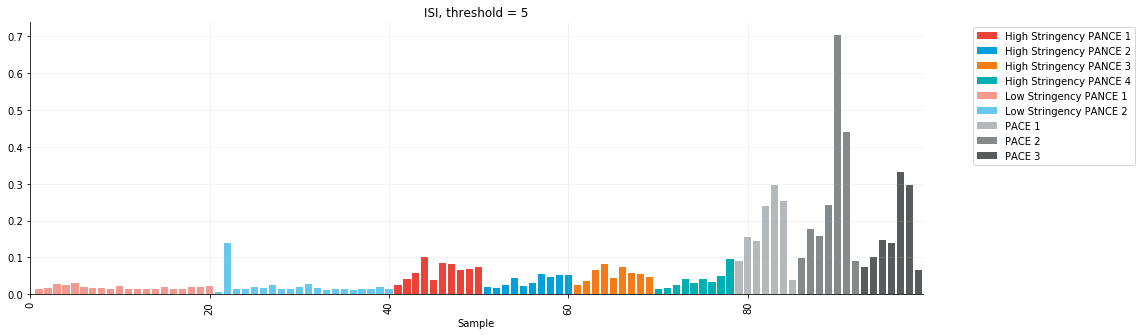

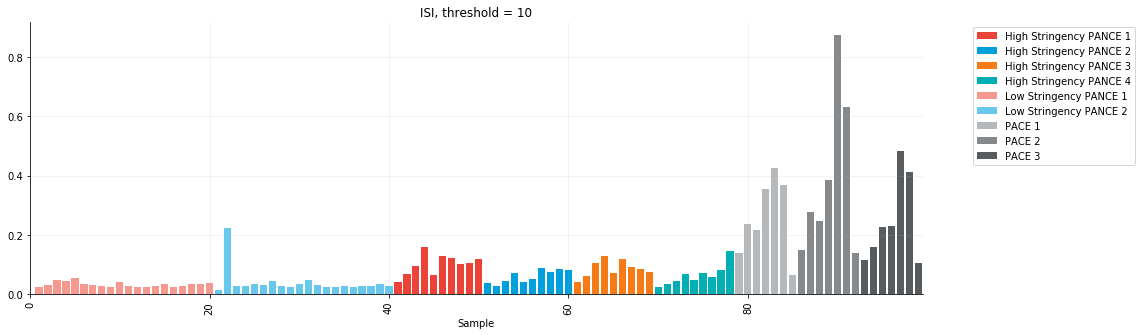

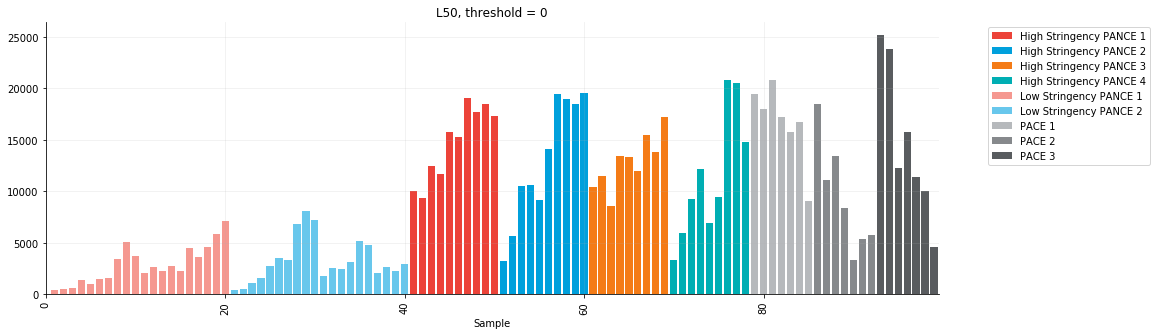

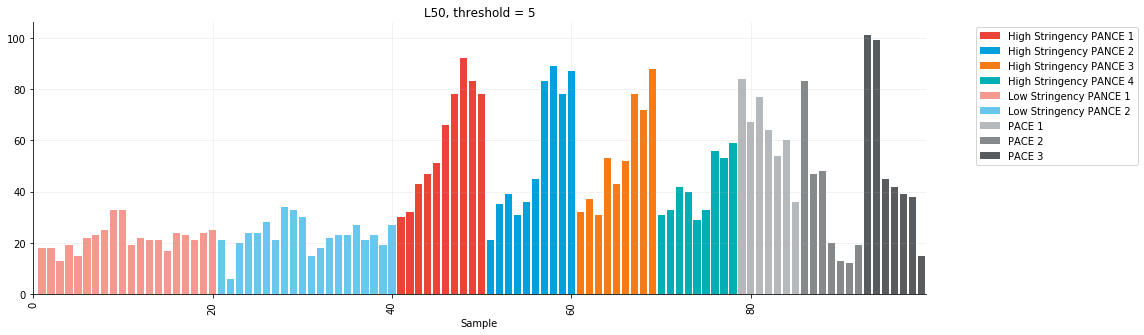

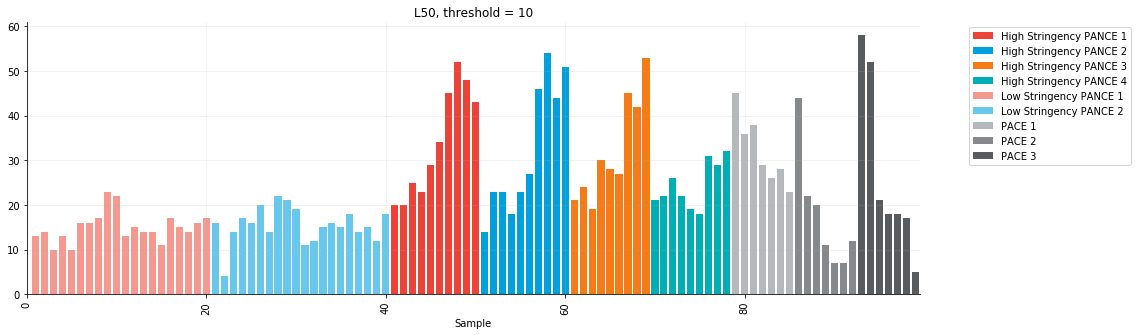

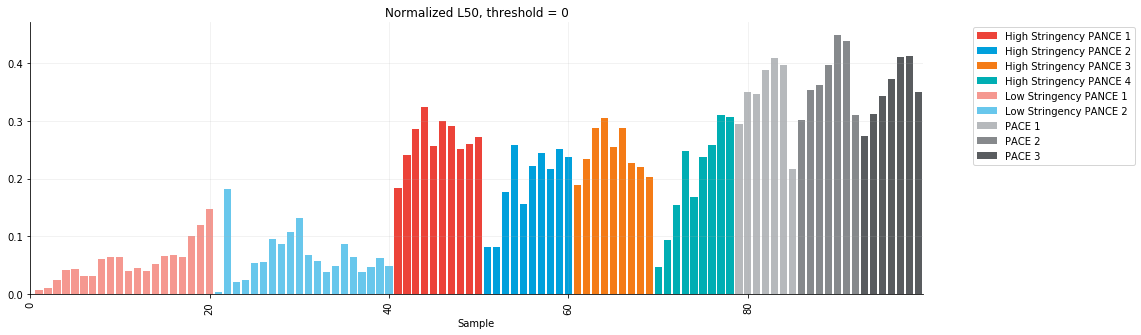

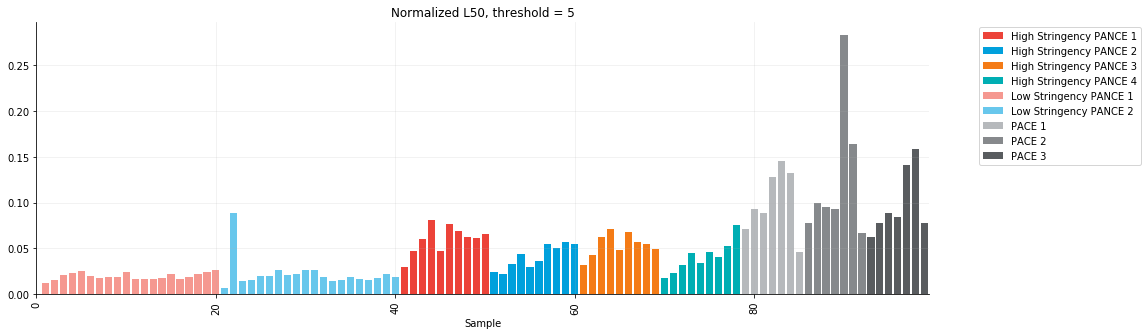

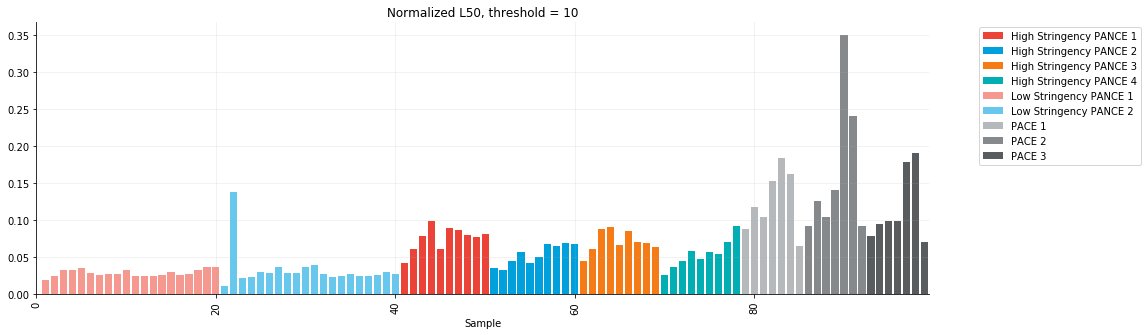

In [134]:
plt_out_dir = ''

for stat_nm in ['Max frequency', 'Entropy', 'ISI', 'L50', 'Normalized L50']:
    for low in [0, 5, 10]:

        dfs = stats_df[stats_df['Threshold'] == low]

        fig, ax = plt.subplots(figsize = (16, 5))
        for regime in sorted(list(set(dfs['Regime']))):
            dfsr = dfs[dfs['Regime'] == regime]
            plt.bar(
                dfsr['Name'],
                dfsr[stat_nm],
                color = dfsr['Color'].iloc[0],
                label = regime,
            )

        sns.despine()
        plt.grid(alpha = 0.2)
        plt.xlim(left = 0, right = 99.5)
        plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')

        plt.title(f'{stat_nm}, threshold = {low}')
        plt.xticks(rotation = 90);

        # plt.ylabel('Diversity score')
        plt.xlabel('Sample')

        plt.show()
        # plt.savefig(plt_out_dir + f'{stat_nm}_filt{low}.png')
        plt.close()

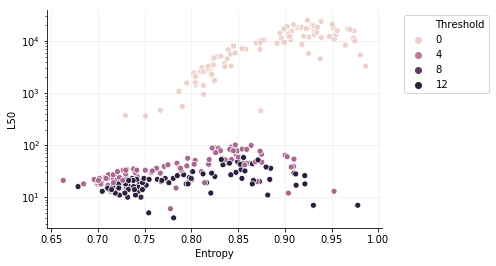

In [137]:
sns.scatterplot(
    x = 'Entropy',
    y = 'L50',
    hue = 'Threshold',
    data = stats_df
)
plt.yscale('log')
plt.grid(alpha = 0.2)
sns.despine()

plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')

In [135]:
from scipy.stats import pearsonr

dfs = stats_df[stats_df['Threshold'] == 5]

pearsonr(dfs['L50'], dfs['Entropy'])

(0.6282784905391898, 3.366610660819929e-12)

In [136]:
from scipy.stats import pearsonr

dfs = stats_df[stats_df['Threshold'] == 5]

pearsonr(dfs['Normalized L50'], dfs['Entropy'])

(0.8800637096059347, 3.8737075294432345e-33)

## L50 curves

In [138]:
from collections import defaultdict
stats_dd = defaultdict(list)

for nm in ddf:
    master_d = ddf[nm]
    low =  5
    d = threshold(master_d, low = low)

    res = 0.05
    for f in np.arange(0, 1 + res, res):
        stats_dd['Name'].append(nm)
        stats_dd['Fraction'].append(f)
        stats_dd['Threshold'].append(low)
        stats_dd['L'].append(calc_L(d, frac = f))
        stats_dd['Normalized L'].append(calc_L_normalized(d, frac = f))
        
curve_df = pd.DataFrame(stats_dd)

design_df['Name'] = design_df['Short name']
curve_df = curve_df.merge(design_df, how = 'outer', on = 'Name')

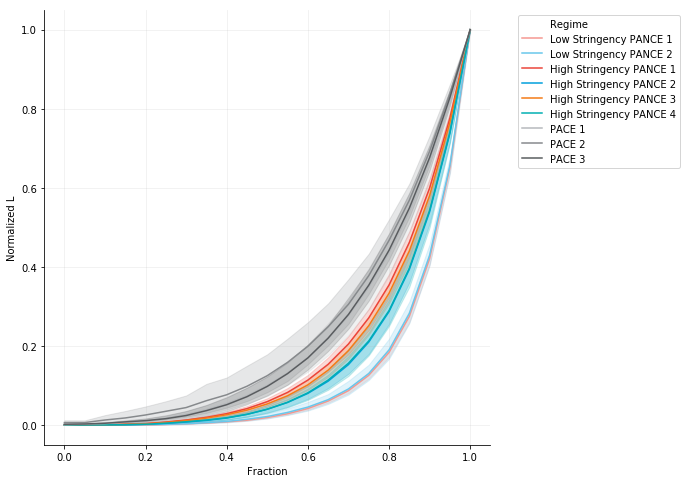

In [149]:
fig, ax = plt.subplots(figsize = (8, 8))

sns.lineplot(
    x = 'Fraction',
    y = 'Normalized L',
    hue = 'Regime',
    palette = palette,
    data = curve_df,
    ax = ax,
)
sns.despine()
plt.grid(alpha = 0.2)
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')

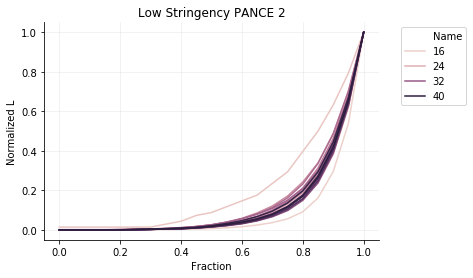

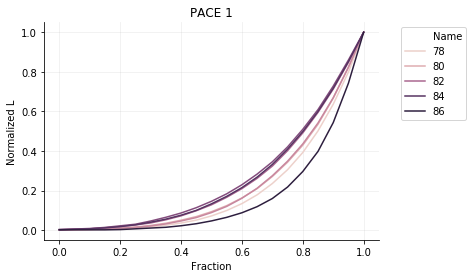

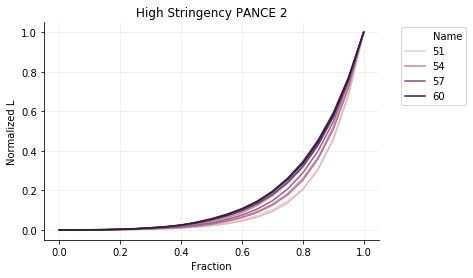

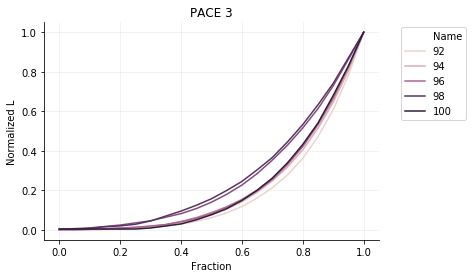

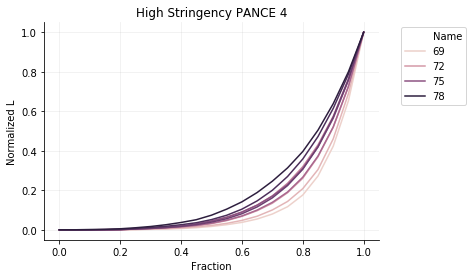

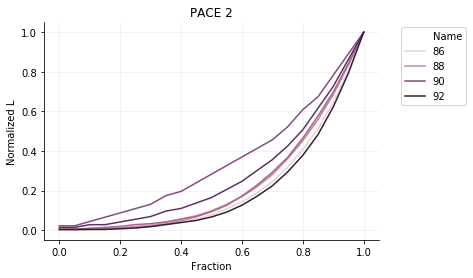

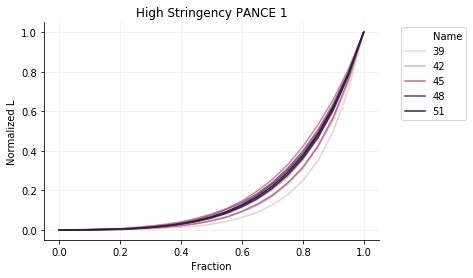

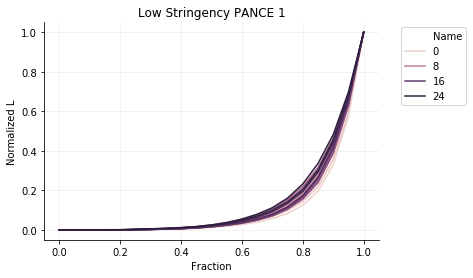

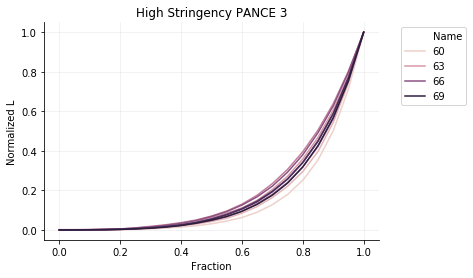

In [148]:
for regime in set(curve_df['Regime']):

    sns.lineplot(
        x = 'Fraction',
        y = 'Normalized L',
        hue = 'Name',
        data = curve_df[curve_df['Regime'] == regime],
    )
    sns.despine()
    plt.grid(alpha = 0.2)
    plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')

    plt.title(f'{regime}')
    plt.show()
    plt.close()